- reference : https://www.youtube.com/watch?v=javWSq-5xzw&list=PLSAJwo7mw8jn8iaXwT4MqLbZnS-LJwnBd&index=28
- **task : n일치 시퀀스로 m일짜리 종가(1개) regression**
- **포인트 : 데이터셋 준비과정, 회귀, 시계열 lstm 다루는거, 구조**
    - 데이터셋 관련 : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- rnn 개념 : https://velog.io/@seojeongbin/RNN
- 이전에 작성한 rnn 코드 : https://github.com/seojeongbin/Pytorch/blob/main/Pytorch_exercise/legacy/8_%EC%A0%95%ED%98%95%EC%8B%9C%EA%B3%84%EC%97%B4RNN%ED%9A%8C%EA%B7%80.ipynb
- nn.LTSM 관련 : https://ok-lab.tistory.com/209

In [1]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.13.0+cu116
Populating the interactive namespace from numpy and matplotlib


# Import Data

In [2]:
start = pd.to_datetime(['2000-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2022-12-31']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + '028050.KS' + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
google = pd.read_csv(url)

<ipython-input-2-ff7345478e1d>:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  start = pd.to_datetime(['2000-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
<ipython-input-2-ff7345478e1d>:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  end = pd.to_datetime(['2022-12-31']).astype(int)[0]//10**9 # convert to unix timestamp.


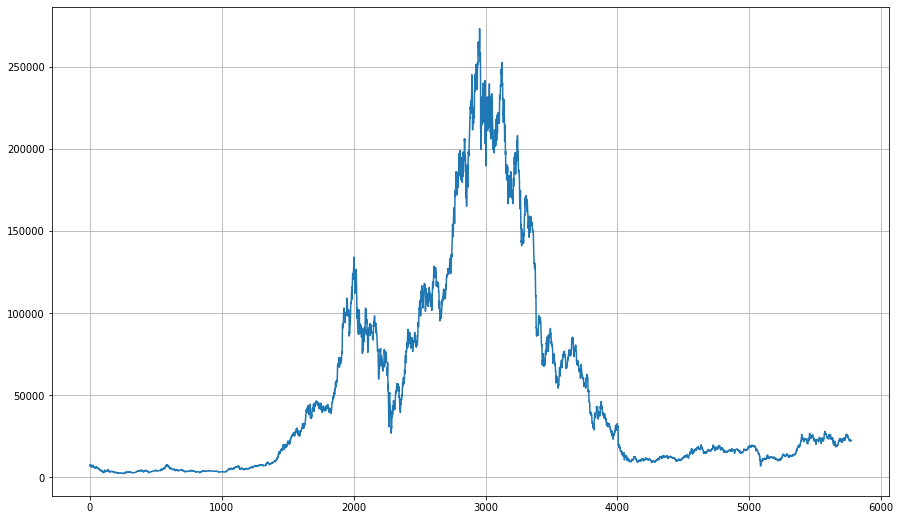

In [3]:
google.Low.plot(grid=True)

In [4]:
google

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6920.0,7990.0,6920.0,7990.0,6161.290527,508900.0
1,2000-01-05,7990.0,8900.0,7500.0,8250.0,6361.783203,1938100.0
2,2000-01-06,8490.0,8580.0,7320.0,7480.0,5768.017090,862800.0
3,2000-01-07,7510.0,8300.0,7350.0,8060.0,6215.269531,1315200.0
4,2000-01-10,8320.0,8490.0,7800.0,7800.0,6014.777344,1405400.0
...,...,...,...,...,...,...,...
5767,2022-12-23,22650.0,22800.0,22150.0,22200.0,22200.000000,913013.0
5768,2022-12-26,22200.0,22300.0,21950.0,22150.0,22150.000000,827477.0
5769,2022-12-27,22300.0,22700.0,22150.0,22650.0,22650.000000,901081.0
5770,2022-12-28,22750.0,23300.0,22650.0,23100.0,23100.000000,784875.0


In [5]:
google.tail()
print(google.isna().sum())

Date         0
Open         9
High         9
Low          9
Close        9
Adj Close    9
Volume       9
dtype: int64


# Data Preparation
> Dataset 이란? => i번째 recored값을 주는 역할임!!
- 데이터셋을 len()하면 길이나오고, [i]하면 그거에 맞는 x[i], y[i] 나오게 하기위함
- __init__ 은 결국 위에 처럼 하기 위한 전처리작업일뿐 

#### Dataset 연습 

In [6]:
class dummySet(Dataset) :
    def __init__(self, num):
        # 선언시 num을 인자로 받으면서 선언함
        self.x = np.array(list(range(num*2))).reshape(-1, 2)
        self.y = np.array(range(num))
        self.test = len(self.x) + len(self.y) ### class 선언 후, .~~ 로 그 값 출력도 가능함 (밑에서 확인)

    def __len__(self):
        # len()하면 길이 나오게 됨
        return len(self.x)

    def __getitem__(self, idx):
        # dataset[idx]하면 그거에 맞는 x,y idx가 나오게 됨!
        return self.x[idx], self.y[idx]

In [7]:
dataset = dummySet(100)
data_loader = DataLoader(dataset, batch_size=3, shuffle=False)
for data_batch in data_loader :
    print(data_batch)
    break

[tensor([[0, 1],
        [2, 3],
        [4, 5]]), tensor([0, 1, 2])]


In [8]:
x, y = dataset[0]
print(f'x : {x}, y : {y}')

x : [0 1], y : 0


In [9]:
dataset = dummySet(100)
dataset.test ### 이런식으로 확인가능

200

#### 실전 적용
- x : [배치 사이즈, 과거 며칠 데이터, 학습에 투입할 피쳐 개수]
    - [2, 10, 6]
    - ❗그런데 lstm 특성 상 앞에 두개 순서가 바뀌어야 한다고 함 : [2, 10, 6] => [10,2, 6]
        - self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True).
        - **찾아보니 이런식으로 batch_first 인자도 있는듯**
- y : [배치사이즈, 향후 예측할 데이터 며칠, 예측할 피쳐 개수]
    - 마지막은 전체 피쳐 다 예측할거면 똑같이 6, 종가 같은 하나의 피쳐만 예측할거면 1
    - [2, 5, 6]

In [10]:
start = pd.to_datetime(['2000-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2022-12-31']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + '028050.KS' + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
google = pd.read_csv(url)

<ipython-input-10-ff7345478e1d>:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  start = pd.to_datetime(['2000-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
<ipython-input-10-ff7345478e1d>:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  end = pd.to_datetime(['2022-12-31']).astype(int)[0]//10**9 # convert to unix timestamp.


In [11]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end): # x_frames : x_seq_len, y_frames : y_seq_len
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start =  pd.to_datetime([start]).astype(int)[0]//10**9
        self.end = pd.to_datetime([end]).astype(int)[0]//10**9
        self.url = 'https://query1.finance.yahoo.com/v7/finance/download/' + self.symbol + '?period1=' + str(self.start) + '&period2=' + str(self.end) + '&interval=1d&events=history'

        self.data = pd.read_csv(self.url)
        self.data = self.data.dropna(axis=0) # 결측치 삭제 코드 (이건 내가 추가함)
        print(self.data.isna().sum()) # 결측치 확인 코드
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    '''
    x seq = 2, y seq = 2 일때 생성가능한 데이터 수
    [1,2,3,4,5] -> [1,2] [3,4] & [2,3] [4,5] -> 가능 데이터 수 = 전체 5 - 2 - 2 + 1 = 2개
    '''

    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Adj Close', 'Volume']] # 칼럼 순서 바꾸는 용
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1)) # 정규화 용
        data = data.values # df -> ndarray
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [12]:
# 데이터셋 시험삼아 출력
testset = StockDataset('028050.KS', 10, 5, '2001-01-01', '2005-01-01')
testloader = DataLoader(testset, 2)
for x, y in testloader: 
    print(x.shape, y.shape)
    break

<ipython-input-11-14741c55ae91>:9: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  self.start =  pd.to_datetime([start]).astype(int)[0]//10**9
<ipython-input-11-14741c55ae91>:10: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  self.end = pd.to_datetime([end]).astype(int)[0]//10**9


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
torch.Size([2, 10, 6]) torch.Size([2, 5, 6])


# Model Define
- .init_hidden 함수를 이용하여 **초기 히든 레이어를 생성**하고, **입력값과 히든 레이어를 .forward 함수에 인자로 주어** 출력값과 히든 레이어를 얻는다.
- 이 출력값과 히든 레이어는 다음 출력값을 얻기 위한 rnn.forward 함수의 인자로 사용되고, 이러한 과정을 기존 학습 문장의 길이만큼 실시하여 모델의 결과를 얻는다.

In [13]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn): # model = LSTM(6, 50, 5, 2, 128, 0.0, True)
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout # float
        self.use_bn = use_bn # boolean
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers) # num_layer : 재귀층을 몇개 stack할것인지
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self): # ❗ 여기도 layers, batch 순서 주의
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers) # sequential하게 진행되도록..
        return regressor
    
    def forward(self, x):
        # print(self.hidden.shape)
        lstm_out, self.hidden = self.lstm(x, self.hidden) # lstm_out은 각 lstm이 뱉는 output. => 우리는 맨 마지막꺼만 이용하게 됨.
        # print(lstm_out.shape)
        # print(self.hidden.shape)
        # print(lstm_out[-1].shape)
        # print(lstm_out[-1].view(self.batch_size, -1).shape)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        # print(y_pred.shape)
        return y_pred

In [14]:
def metric(y_pred, y_true): # 그냥 우리만의 metric을 만듦
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

# Train, Validate, Test 

In [15]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True) # 이거 drop_last는 그 시계열 window size 특성땜에 이렇게 한듯
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.transpose(0, 1).float().to(args.device) # X : [10, n, 6] -> [n, 10, 6] batch랑 x seq len 바꿔주는 용
        y_true = y[:, :, 3].float().to(args.device) # Y : [10, m, 1] : 종가예측. 종가가 3번째 칼럼임.
        #print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [16]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [17]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc

In [18]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(model, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# Manage Experiment

In [19]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [20]:

def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [21]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '028050.KS'
args.batch_size = 128
args.x_frames = 5
args.y_frames = 5

In [22]:
trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, '2000-01-01', '2012-01-01')
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, '2012-01-01', '2016-01-01')
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, '2016-01-01', '2019-01-01')
partition = {'train': trainset, 'val': valset, 'test' : testset}

<ipython-input-11-14741c55ae91>:9: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  self.start =  pd.to_datetime([start]).astype(int)[0]//10**9
<ipython-input-11-14741c55ae91>:10: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  self.end = pd.to_datetime([end]).astype(int)[0]//10**9


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [23]:
# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 2


# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [1,2,3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=2, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=1e-05, lr=0.001, n_layers=1, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)


KeyError: ignored

> 판다스 관련 에러라서 def load_exp_result(exp_name) 여기서 에러나지 않았을까 예상됨. experiment 방식을 그냥 간단하게 하면 될듯

In [ ]:
var1 = 'lr'
var2 = 'n_layers'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)